In [1]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/cropped
!unzip \*.zip  && rm *.zip

In [6]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/cropped/car_data_cropped/car_data/train/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/cropped/car_data_cropped/car_data/train/',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/cropped/car_data_cropped/car_data/test/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 6535 images belonging to 49 classes.
Found 1609 images belonging to 49 classes.
Found 8041 images belonging to 49 classes.


In [7]:
def build_vgg16_transfer_learning_model(img_height=224,img_width=224,num_classes=49):

    # base model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = False

    # add the top
    input_image = tf.keras.Input(shape=(img_height, img_width, 3))
    x1 = base_model(input_image, training=False)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = input_image, outputs =out)
  
    #compile and return
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [17]:
model = build_vgg16_transfer_learning_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 1,229,361
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
model_name = "vgg16_cars_49_classes_cropped.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [19]:
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
205/205 [==============================] - 124s 601ms/step - loss: 3.4671 - accuracy: 0.1192 - val_loss: 2.9992 - val_accuracy: 0.1939
Epoch 2/100
205/205 [==============================] - 122s 593ms/step - loss: 2.7911 - accuracy: 0.2460 - val_loss: 2.6270 - val_accuracy: 0.2983
Epoch 3/100
205/205 [==============================] - 121s 590ms/step - loss: 2.4214 - accuracy: 0.3428 - val_loss: 2.4183 - val_accuracy: 0.3605
Epoch 4/100
205/205 [==============================] - 122s 595ms/step - loss: 2.1708 - accuracy: 0.4196 - val_loss: 2.2455 - val_accuracy: 0.3915
Epoch 5/100
205/205 [==============================] - 122s 594ms/step - loss: 1.9592 - accuracy: 0.4929 - val_loss: 2.1652 - val_accuracy: 0.3996
Epoch 6/100
205/205 [==============================] - 122s 595ms/step - loss: 1.8730 - accuracy: 0.5078 - val_loss: 2.1047 - val_accuracy: 0.4226
Epoch 7/100
205/205 [==============================] - 122s 598ms/step - loss: 1.7859 - accuracy: 0.5277 - val_loss: 2

In [20]:
## finetune model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224,224,3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(224,224,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(49,activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 15,944,049
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
batch = 128
num_epochs = 100
history_2 = model.fit(train_generator,
          validation_data = val_generator,
          epochs=num_epochs,
          verbose=1,
          batch_size=batch,
          callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
205/205 [==============================] - 128s 613ms/step - loss: 1.2945 - accuracy: 0.6561 - val_loss: 1.6354 - val_accuracy: 0.5308
Epoch 2/100
205/205 [==============================] - 126s 615ms/step - loss: 1.1192 - accuracy: 0.6713 - val_loss: 1.5709 - val_accuracy: 0.5587
Epoch 3/100
205/205 [==============================] - 124s 606ms/step - loss: 1.0304 - accuracy: 0.6840 - val_loss: 1.5445 - val_accuracy: 0.5643
Epoch 4/100
205/205 [==============================] - 122s 597ms/step - loss: 1.0020 - accuracy: 0.6959 - val_loss: 1.5031 - val_accuracy: 0.5625
Epoch 5/100
205/205 [==============================] - 122s 596ms/step - loss: 0.9591 - accuracy: 0.7155 - val_loss: 1.4841 - val_accuracy: 0.5811
Epoch 6/100
205/205 [==============================] - 123s 600ms/step - loss: 0.9136 - accuracy: 0.7264 - val_loss: 1.4710 - val_accuracy: 0.5805
Epoch 7/100
205/205 [==============================] - 124s 606ms/step - loss: 0.9139 - accuracy: 0.7257 - val_loss: 1

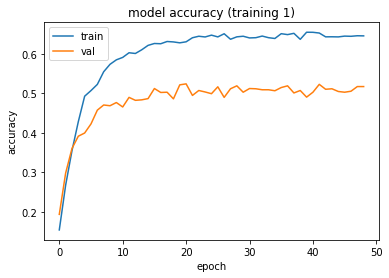

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
model.load_weights('/content/gdrive/MyDrive/Kaggle/cropped/vgg16_cars_49_classes_cropped.h5')
metrics = model.evaluate(test_generator)

252/252 [==============================] - 52s 205ms/step - loss: 1.2314 - accuracy: 0.6596


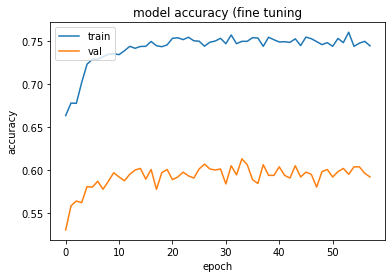

In [26]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy (fine tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

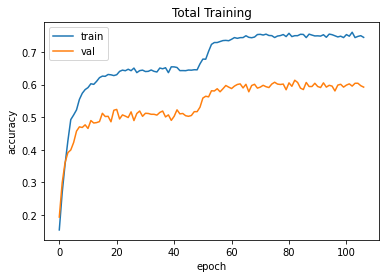

In [27]:
acc_total = np.zeros(len(history.history['accuracy']) + len(history_2.history['accuracy']))
val_total = np.zeros(len(history.history['val_accuracy']) + len(history_2.history['val_accuracy']))

for i in range(len(history.history['accuracy'])):
  acc_total[i] = history.history['accuracy'][i]
  val_total[i] = history.history['val_accuracy'][i]
  
for j in range(len(history_2.history['accuracy'])):
  acc_total[j+len(history.history['accuracy'])] = history_2.history['accuracy'][j]
  val_total[j+len(history.history['val_accuracy'])] = history_2.history['val_accuracy'][j]



plt.plot(acc_total)
plt.plot(val_total)
plt.title('Total Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

In [28]:
max(history_2.history['val_accuracy'])

0.6134244799613953

In [29]:
max(history_2.history['accuracy'])

0.7605202794075012